In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
data = np.load('/content/drive/MyDrive/data.npy')
labels = np.load('/content/drive/MyDrive/labels.npy')

In [3]:
#setting numpy and tensor flow seed to ensure reproducibility of the results
import tensorflow as tf

# Set the seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size= 0.2, stratify=labels, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size= 0.25, stratify=y_train, random_state=42) #split 0.25 this time, because 0.25*0.8 = a 0.2 split for validation
print(str(X_train.shape[0]) + ' train samples')
print(str(X_validation.shape[0]) + ' validation samples')
print(str(X_test.shape[0]) + ' test samples')

3834 train samples
1279 validation samples
1279 test samples


In [5]:
# encode Y class values as integers
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_validation = encoder.transform(y_validation)
y_test = encoder.transform(y_test)

In [6]:
# Converting to categorical
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train) 
y_validation_cat = to_categorical(y_validation) 
y_test_cat = to_categorical(y_test)

In [7]:
# convert from integers to floats
X_train = X_train.astype('float32')
X_validation = X_validation.astype('float32')
X_test = X_test.astype('float32')

# Normalizing x values to 0-1
X_train = X_train / 255.0
X_validation = X_validation / 255.0
X_test = X_test / 255.0

In [8]:
#VGG16 Dropout and Early Stopping
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import layers
from keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load pre-trained model
model = VGG16( weights="imagenet",include_top=False, input_shape=(X_train[0].shape))


for layer in model.layers:
    layer.trainable = False

flat1 = layers.Flatten()(model.layers[-1].output)
# Add Dense layer
class1 = layers.Dense(156, activation='relu')(flat1)
# Add Dropout layer
dropout1 = layers.Dropout(0.5)(class1)
# Add output layer with softmax activation
output = layers.Dense(4, activation='softmax')(dropout1)
# Define new model
model = Model(inputs=model.inputs, outputs=output)


from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

history = model.fit(X_train, y_train_cat, validation_data=(X_validation, y_validation_cat), epochs=15, batch_size=32, callbacks=[es])


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/15
120/120 [==============================] - 27s 133ms/step - loss: 0.7762 - accuracy: 0.6847 - val_loss: 0.5775 - val_accuracy: 0.7701
Epoch 2/15
120/120 [==============================] - 11s 96ms/step - loss: 0.5987 - accuracy: 0.7567 - val_loss: 0.5419 - val_accuracy: 0.7897
Epoch 3/15
120/120 [==============================] - 14s 115ms/step - loss: 0.5654 - accuracy: 0.7700 - val_loss: 0.5488 - val_accuracy: 0.7725
Epoch 4/15
120/120 [==============================] - 14s 116ms/step - loss: 0.5346 - accuracy: 0.7791 - val_loss: 0.5425 - val_accuracy: 0.7944
Epoch 5/15
120/120 [==============================] - 14s 115ms/step - loss: 0.5101 - accuracy: 0.7916 - val_loss: 0.5207 - val_accuracy: 0.7764
Epoch 6/15
120/120 [==============================] - 14s 114ms/step - loss: 0.4984 - accuracy: 0.7966 - val_loss: 0.5116 - val_accuracy: 0.7991
Epoch 7/15
120/120 [==============================] - 11s 95ms/ste

In [9]:
test_loss, test_acc = model.evaluate(X_validation, y_validation_cat)
print(test_acc)

40/40 [==============================] - 3s 71ms/step - loss: 0.5128 - accuracy: 0.8069
0.8068803548812866


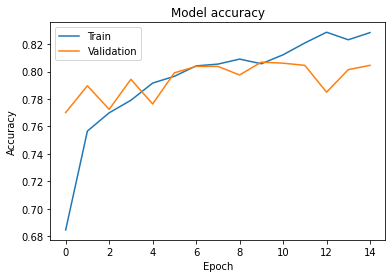

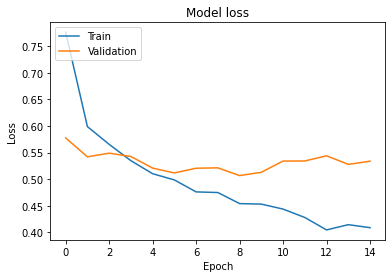

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
'''retrain model (0.80 acc) on train_set + val_set'''

## Concatenate training and validation sets
X_train = np.concatenate((X_train, X_validation), axis=0)
y_train = np.concatenate((y_train, y_validation), axis=0)

## converting to categorical
y_train_cat = to_categorical(y_train)

##retrain
history_new = history = model.fit(X_train, y_train_cat, validation_data=(X_validation, y_validation_cat), epochs=15, batch_size=32, callbacks=[es])

Epoch 1/15
160/160 [==============================] - 19s 120ms/step - loss: 0.4882 - accuracy: 0.7989 - val_loss: 0.4718 - val_accuracy: 0.8077
Epoch 2/15
160/160 [==============================] - 17s 106ms/step - loss: 0.4647 - accuracy: 0.8034 - val_loss: 0.4427 - val_accuracy: 0.8077
Epoch 3/15
160/160 [==============================] - 17s 105ms/step - loss: 0.4668 - accuracy: 0.8052 - val_loss: 0.4309 - val_accuracy: 0.8178
Epoch 4/15
160/160 [==============================] - 14s 90ms/step - loss: 0.4436 - accuracy: 0.8083 - val_loss: 0.4422 - val_accuracy: 0.8131
Epoch 5/15
160/160 [==============================] - 14s 90ms/step - loss: 0.4440 - accuracy: 0.8081 - val_loss: 0.3997 - val_accuracy: 0.8249
Epoch 6/15
160/160 [==============================] - 14s 90ms/step - loss: 0.4256 - accuracy: 0.8226 - val_loss: 0.4195 - val_accuracy: 0.8264
Epoch 7/15
160/160 [==============================] - 17s 105ms/step - loss: 0.4171 - accuracy: 0.8275 - val_loss: 0.3744 - val_accur

In [13]:
''' predict with retrained model 5'''
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1), target_names=np.unique(labels)))

40/40 [==============================] - 3s 67ms/step
                        precision    recall  f1-score   support

   Bacterial Pneumonia       0.76      0.91      0.83       564
              COVID-19       0.55      0.24      0.33        25
No Pneumonia (healthy)       0.98      0.88      0.93       321
       Viral Pneumonia       0.72      0.59      0.65       369

              accuracy                           0.80      1279
             macro avg       0.75      0.66      0.69      1279
          weighted avg       0.80      0.80      0.79      1279



In [14]:
y_before = model.predict(X_test)
y_pred = y_before.argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)
n_classes = len(np.unique(labels))
import pandas as pd

from sklearn.metrics import precision_recall_fscore_support
res = []
for l, name in zip(range(n_classes),np.unique(labels)):
    prec,recall,fscore,_ = precision_recall_fscore_support(np.array(y_true)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None, beta=1)
    res.append([name,recall[0],recall[1],fscore[0]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity', 'f1score'])

40/40 [==============================] - 3s 68ms/step


,class,sensitivity,specificity,f1score
0,Bacterial Pneumonia,0.772028,0.914894,0.839544
1,COVID-19,0.996013,0.240000,0.990484
2,No Pneumonia (healthy),0.994781,0.878505,0.977436
3,Viral Pneumonia,0.907692,0.590786,0.875464
